**Date**: 2019-01-29

**Authors**: Adam Stafford

**Purpose**: To test whether shuffling the input improves the accuracy when using a bidirectional LSTM.

This notebook tests a naive alignment scheme that selects the first 1000 positions of a DNA sequence (add null positions to the end if a sequence is shorter than 1000). The sequences are shuffled before feeding into the neural network.

**Background**:
- The idea of this experiment is based on the understanding that any sequence bears more resemblance with its 23 'siblings' (which are next to each other in the list of sequences before shuffling). Without shuffling, either all siblings are in the training set, or all of them are in the validation set. By shuffling the sequences, all siblings would be randomly distributed into the training set and the validation set. We might be able to extract more information for a sequence based on those of its siblings that are distributed into the training set.

**Experiment**:

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Load the `pickle` buffered list:

In [2]:
with open("../data/new_list_buffer.txt", "rb") as buff:
    seq_record_list = pickle.load(buff)

The following cell retains only 4800 sequences, for the purpose of testing speed. It also randomly shuffles the 4800 sequences.

In [3]:
seq_record_list = seq_record_list[:4800]
from random import shuffle
shuffle(seq_record_list)

The following cell transforms the data into a format that is recognizable by the neural network model.

In [4]:
# A helper function to flatten a 2d list to 1d.
# Input: [[1, 2], [2, 3], [3, 4, 5]]
# Output: [1, 2, 2, 3, 3, 4, 5]
def flatten(lst):
    new_lst = []
    for sub_lst in lst:
        for item in sub_lst:
            new_lst.append(item)
    return new_lst

# A helper function to transform a lst so that its length becomes read_len by:
# 1. If len(lst) > read_len, curtail the end of the lst.
# 2. If len(lst) < read_len, keep extending the end of the lst with 0 (NA).
def curtail(lst, read_len):
    if len(lst) > read_len:
        lst = lst[:read_len]
    else:
        for i in range(read_len - len(lst)):
            lst.append([0, 0, 0, 0, 0, 0, 0, 0])
    return lst

# Produce the train-test split
# length_read: the length that you want all DNA sequences to conform to
def prepare_input(training_size, test_size, length_read):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    seq_count = 0
    while seq_count < training_size:
        X_train.append(flatten(curtail(seq_record_list[seq_count][3], length_read)))
        y_train.append(int(seq_record_list[seq_count][1]))
        seq_count += 1
    while seq_count < (training_size + test_size):
        X_test.append(flatten(curtail(seq_record_list[seq_count][3], length_read)))
        y_test.append(int(seq_record_list[seq_count][1]))
        seq_count += 1
    return X_train, y_train, X_test, y_test

# Turn list into numpy tensors that can directly feed into a neural network model
def to_np_array(X_train, y_train, X_test, y_test):
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    if len(y_train.shape) == 1:
        y_train = np.transpose(np.array([y_train]))
    X_test = np.array(X_test)
    y_test = np.transpose(np.array(y_test))
    if len(y_test.shape) == 1:
        y_test = np.transpose(np.array([y_test]))
    return X_train, y_train, X_test, y_test

In [5]:
X_train, y_train, X_test, y_test = prepare_input(4320, 480, 1000)
X_train, y_train, X_test, y_test = to_np_array(X_train, y_train, X_test, y_test)
[X_train.shape, y_train.shape, X_test.shape, y_test.shape]

[(4320, 8000), (4320, 1), (480, 8000), (480, 1)]

The following cells build a recurrent network with one bidirectional LSTM layer.

In [6]:
from keras.models import Model, Sequential
from keras.layers import Dense, CuDNNLSTM, Bidirectional

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
X_train_rnn = X_train.reshape(4320, 1000, 8)

In [8]:
model = Sequential()
#model.add(CuDNNLSTM(8, input_shape=(1000, 8), return_sequences=True))
model.add(Bidirectional(CuDNNLSTM(8), input_shape=(1000, 8)))
#model.add(CuDNNLSTM(8, return_sequences=True))
#model.add(CuDNNLSTM(4, return_sequences=True))
#model.add(CuDNNLSTM(4))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train_rnn, y_train, epochs=150, batch_size=128, validation_split=0.1)

Train on 3888 samples, validate on 432 samples
Epoch 1/150
3888/3888 [==============================] - 91s 23ms/step - loss: 0.6928 - acc: 0.5064 - val_loss: 0.6935 - val_acc: 0.5093
Epoch 2/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.6817 - acc: 0.5358 - val_loss: 0.6843 - val_acc: 0.5255
Epoch 3/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.6723 - acc: 0.5682 - val_loss: 0.6757 - val_acc: 0.5718
Epoch 4/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.6639 - acc: 0.5939 - val_loss: 0.6683 - val_acc: 0.5856
Epoch 5/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.6577 - acc: 0.6016 - val_loss: 0.6633 - val_acc: 0.6065
Epoch 6/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.6516 - acc: 0.6170 - val_loss: 0.6586 - val_acc: 0.6343
Epoch 7/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.6451 - acc: 0.6312 - val_loss: 0.6537 - val_acc: 0.6458
Epoch 

Epoch 61/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.4502 - acc: 0.8022 - val_loss: 0.4947 - val_acc: 0.7616
Epoch 62/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.4455 - acc: 0.8030 - val_loss: 0.4944 - val_acc: 0.7546
Epoch 63/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.4440 - acc: 0.8063 - val_loss: 0.4900 - val_acc: 0.7523
Epoch 64/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.4420 - acc: 0.8099 - val_loss: 0.4870 - val_acc: 0.7616
Epoch 65/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.4396 - acc: 0.8063 - val_loss: 0.4818 - val_acc: 0.7778
Epoch 66/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.4357 - acc: 0.8130 - val_loss: 0.4897 - val_acc: 0.7755
Epoch 67/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.4341 - acc: 0.8120 - val_loss: 0.4847 - val_acc: 0.7569
Epoch 68/150
3888/3888 [========================

3888/3888 [==============================] - 5s 1ms/step - loss: 0.3459 - acc: 0.8627 - val_loss: 0.4278 - val_acc: 0.8125
Epoch 122/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.3460 - acc: 0.8627 - val_loss: 0.4521 - val_acc: 0.8241
Epoch 123/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.3456 - acc: 0.8619 - val_loss: 0.4493 - val_acc: 0.8079
Epoch 124/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.3432 - acc: 0.8621 - val_loss: 0.4363 - val_acc: 0.8171
Epoch 125/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.3431 - acc: 0.8611 - val_loss: 0.4672 - val_acc: 0.8171
Epoch 126/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.3427 - acc: 0.8632 - val_loss: 0.4374 - val_acc: 0.8287
Epoch 127/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.3390 - acc: 0.8652 - val_loss: 0.4286 - val_acc: 0.8264
Epoch 128/150
3888/3888 [==============================

**Result**:

The following cell **visualize** the training/validation accuracies and losses over each epoch.

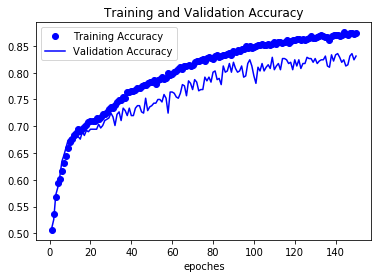

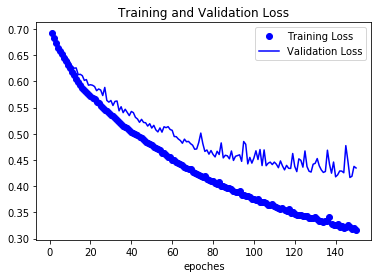

In [9]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoches')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoches')
plt.legend()

plt.show()

In [10]:
import utility
utility.save_model(model, 'models/adam_2019_01_29.json', 'models/adam_2019_01_29_weights.h5')


Save model to models/adam_2019_01_29.json


- The validation trend now follows closely to the training trend.

**Conclusion**:

- The result of the experiment demonstrates a marked improvement over previous experiments and suggests that the combination of shuffling the data and using a bidirectional neural network improves accuracy.
- To summarize, for any sequence, its most resemblance sequences are its 23 ‘siblings’. If we don’t shuffle the data, either all 24 ‘siblings’ are in the training data, or all of them are in the validation data. By shuffling them, the 24 ‘siblings’ are randomly distributed into both training and validation data, allowing us to extract more information.